# Identify what makes song motifs neurally similar vs different

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
def get_snippets(T_SNP, MIN_GAP, MIN_POWER=0, MAX_POWER=1):
    # get snippets
    nt_snp = int(round(T_SNP*FPS))
    t_snp = np.arange(nt_snp)*DT

    snps = []

    # go through all songs
    for ctr, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=int(round(MIN_GAP/DT)))
        
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [
            seg[:nt_snp] for seg in segs
            if (len(seg) >= nt_snp)
            and (np.mean(seg[:nt_snp] > 0) > MIN_POWER)
            and (np.mean(seg[:nt_snp] > 0) < MAX_POWER)
        ]
        
        snps.extend(segs)

    snps = np.array(snps)
    nsnp = len(snps)

    i_ss = [(snp == 1).astype(float) for snp in snps]
    i_ps = [(snp == 2).astype(float) for snp in snps]
    
    return snps, i_ss, i_ps

In [5]:
def smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, dt, adapt='MA'):
    t = np.arange(len(i_s))*dt
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integral
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        da_s = (dt/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ss[ct, :] = a_ss[ct-1, :] + da_s
        
        da_p = (dt/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + da_p
        
    return rs, vs, a_ss, a_ps, t

In [6]:
def get_nrl_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt, alpha):
    nrl_basis = np.nan*np.zeros((len(tau_r), len(motif_basis)))
    rs_full = []

    for cmotif, motif in enumerate(motif_basis):
        i_s = (motif == 1).astype(float)
        i_p = (motif == 2).astype(float)

        tmotif = np.arange(len(motif))*DT

        rs = smlt_v(i_s, i_p, tau_r, tau_a, x_s, x_p, DT, adapt=adapt)[0]

        nrl_basis[:, cmotif] = rs[-1, :]
        rs_full.append(rs)
        
    rgr = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    w_readout = rgr.fit(nrl_basis.T, np.eye(len(motif_basis))).coef_.T
    
    return nrl_basis, w_readout, rs_full

In [7]:
def get_alignment(r_0, r_1):
    r_0_hat = r_0/np.linalg.norm(r_0)
    r_1_hat = r_1/np.linalg.norm(r_1)
    return r_0_hat@r_1_hat

In [8]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

<BarContainer object of 20 artists>

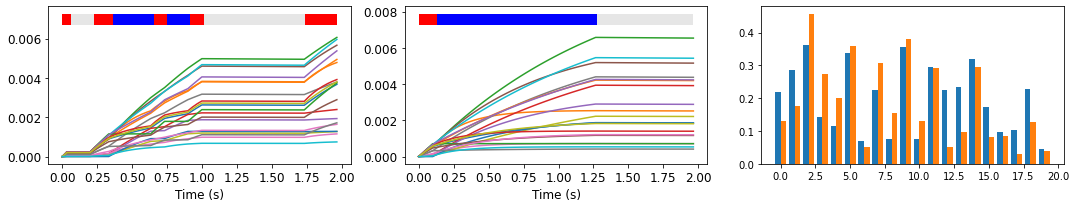

In [9]:
motifs, i_ss, i_ps = get_snippets(T_SNP=2, MIN_GAP=3, MIN_POWER=0.25)
imotifs = np.random.choice(range(len(motifs)), 2, replace=False)
motif_basis = [motifs[imotif] for imotif in imotifs]

ALPHA = 1e-9
nrl_basis_ma, w_ma, rs_full_ma = get_nrl_basis(motif_basis, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)

fig, axs = plt.subplots(1, 3, figsize=(15, 3), tight_layout=True)

for cmotif, imotif in enumerate(imotifs):
    motif = motifs[imotif]
    t_motif = np.arange(len(motif))*DT
    
    axs[cmotif].plot(t_motif, rs_full_ma[cmotif])
    plot_b(axs[cmotif], t_motif, motif, [0, t_motif.max(), 1.1*rs_full_ma[cmotif].max(), 1.2*rs_full_ma[cmotif].max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[cmotif], x_label='Time (s)')
    
rs_normed = [
    rs_full_ma[0][-1, :]/np.linalg.norm(rs_full_ma[0][-1, :]),
    rs_full_ma[1][-1, :]/np.linalg.norm(rs_full_ma[1][-1, :]),
]
axs[2].bar(np.arange(N), rs_normed[0], align='edge', width=-.4)
axs[2].bar(np.arange(N), rs_normed[1], align='edge', width=.4)

In [10]:
T_SNP = 2
MIN_POWER = .25
ALPHA = 1e-9

motifs, i_ss, i_ps = get_snippets(T_SNP=T_SNP, MIN_GAP=T_SNP, MIN_POWER=MIN_POWER)

NPAIR = 5000

motif_pairs = []
r_pairs = []
alignments = []

for cpair in range(NPAIR):
    imotifs = np.random.choice(range(len(motifs)), 2, replace=False)
    motif_pair = [motifs[imotif] for imotif in imotifs]
    
    motif_pairs.append(motif_pair)

    nrl_basis_ma, w_ma, rs_full_ma = get_nrl_basis(motif_pair, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)
    
    r_pair = [rs[-1, :] for rs in rs_full_ma]
    r_pairs.append(r_pair)
    
    alignments.append(get_alignment(*r_pair))

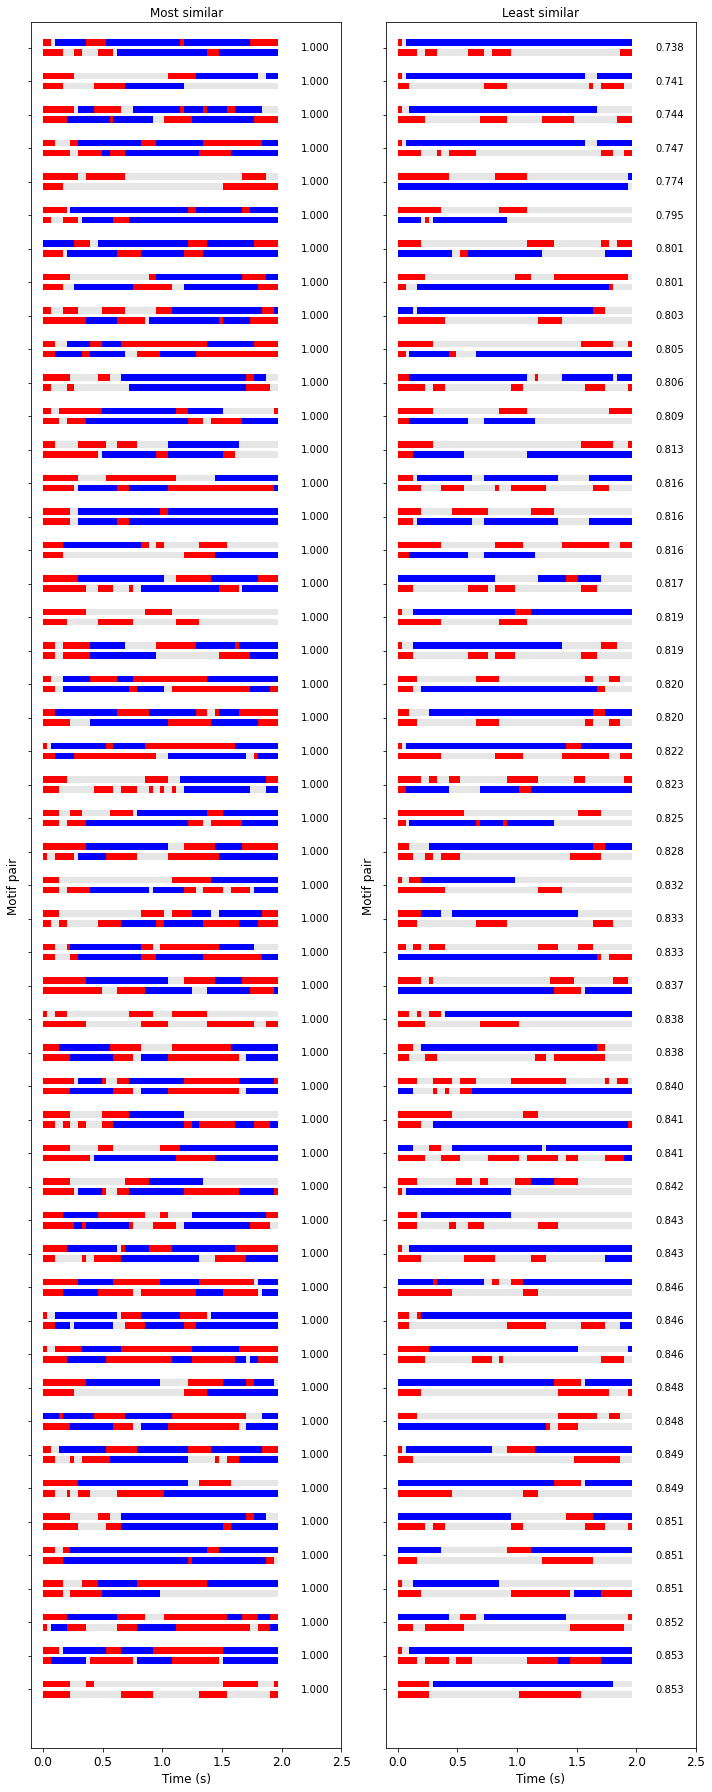

In [11]:
idx_sorted = np.argsort(alignments)[::-1]
nextreme = 50

fig, axs = plt.subplots(1, 2, figsize=(10, 25), tight_layout=True)

# most similar motifs
y_ticks = []
for cidx, idx in enumerate(idx_sorted[:nextreme]):
    motif_pair = motif_pairs[idx]
    alignment = alignments[idx]

    t_motifs = [np.arange(len(motif))*DT for motif in motif_pair]
    
    plot_b(axs[0], t_motifs[0], motif_pair[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[0], t_motifs[1], motif_pair[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])

    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[0].text(t_text, -cidx-.25, f'{alignment:.3f}', va='center')
    
    y_ticks.append(-cidx-.25)
    
set_plot(axs[0], x_lim=(-.1, T_SNP*1.25), y_lim=(-nextreme-1, .5), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair', title='Most similar')

# least similar motifs
y_ticks = []
for cidx, idx in enumerate(idx_sorted[::-1][:nextreme]):
    motif_pair = motif_pairs[idx]
    alignment = alignments[idx]

    t_motifs = [np.arange(len(motif))*DT for motif in motif_pair]
    
    plot_b(axs[1], t_motifs[0], motif_pair[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[1], t_motifs[1], motif_pair[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])

    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[1].text(t_text, -cidx-.25, f'{alignment:.3f}', va='center')
    
    y_ticks.append(-cidx-.25)
    
set_plot(axs[1], x_lim=(-.1, T_SNP*1.25), y_lim=(-nextreme-1, .5), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair', title='Least similar')

Plot motif-difference features vs alignment

In [12]:
diff_feats = {}

# diff total sine or total pulse
diff_feats['sng_total'] = np.abs([(motif_0 > 0).sum()*DT - (motif_1 > 0).sum()*DT for motif_0, motif_1 in motif_pairs])
diff_feats['s_total'] = np.abs([(motif_0 == 1).sum()*DT - (motif_1 == 1).sum()*DT for motif_0, motif_1 in motif_pairs])
diff_feats['p_total'] = np.abs([(motif_0 == 2).sum()*DT - (motif_1 == 2).sum()*DT for motif_0, motif_1 in motif_pairs])
diff_feats['p_minus_s'] = np.abs([
    ( (motif_0 == 2).sum()*DT - (motif_0 == 1).sum()*DT )
    - ( (motif_1 == 2).sum()*DT - (motif_1 == 1).sum()*DT )
    for motif_0, motif_1 in motif_pairs])

diff_feats['s_frac'] = np.abs([
    (motif_0 == 1).sum()*DT/((motif_0 > 0).sum()*DT)
    - (motif_1 == 1).sum()*DT/((motif_0 > 0).sum()*DT)
    for motif_0, motif_1 in motif_pairs])

diff_feats['p_frac'] = np.abs([
    (motif_0 == 2).sum()*DT/((motif_0 > 0).sum()*DT)
    - (motif_1 == 2).sum()*DT/((motif_0 > 0).sum()*DT)
    for motif_0, motif_1 in motif_pairs])

diff_feats['p_minus_s_normed'] = np.abs([
    ( (motif_0 == 2).sum()*DT - (motif_0 == 1).sum()*DT )/((motif > 0).sum()*DT)
    - ( (motif_1 == 2).sum()*DT - (motif_1 == 1).sum()*DT )/((motif > 0).sum()*DT)
    for motif_0, motif_1 in motif_pairs])

diff_feats['max_s_p_total'] = np.array([diff_feats['s_total'], diff_feats['p_total']]).max(axis=0)

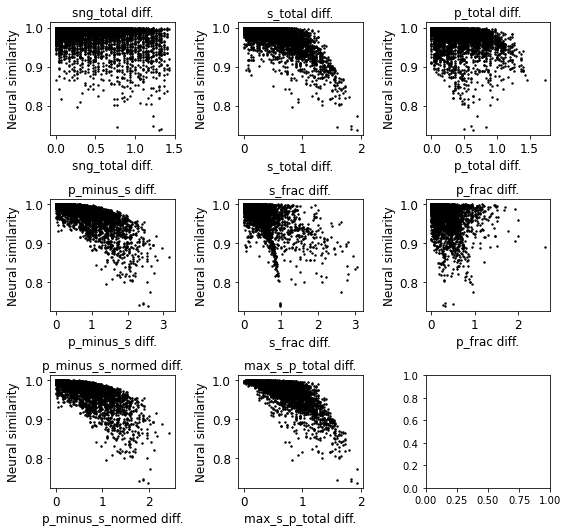

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(8, 7.5), tight_layout=True)

for key, ax in zip(diff_feats, axs.flatten()):
    ax.scatter(diff_feats[key], alignments, s=2, c='k')
    
    set_plot(ax, x_label=f'{key} diff.', y_label='Neural similarity', title=f'{key} diff.')
    
fig.savefig('ms/fig_5_motif_similarity.svg')

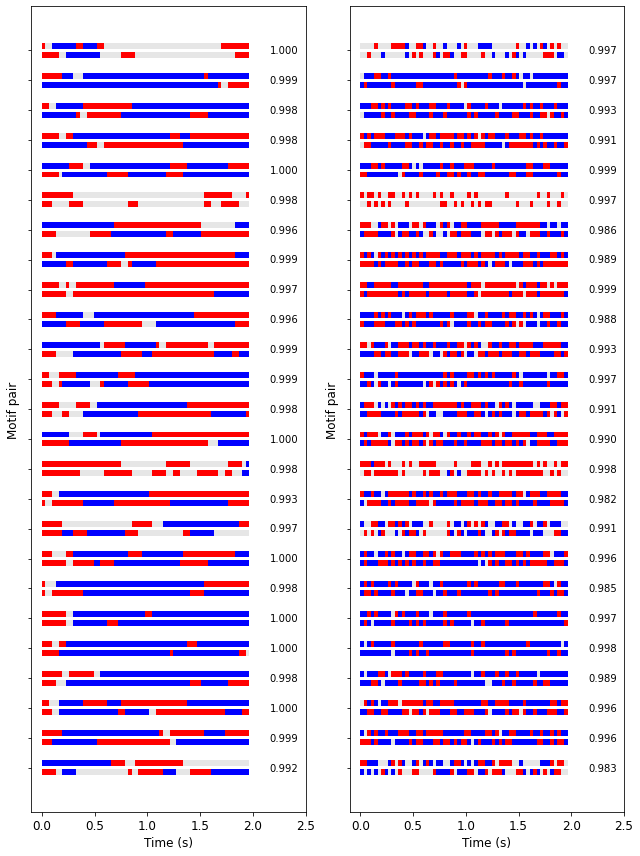

In [34]:
idx_same_s_p = np.nonzero(diff_feats['max_s_p_total'] < .05)[0]

fig, axs = plt.subplots(1, 2, figsize=(9, 12), tight_layout=True)

# most similar motifs
y_ticks = []
for cidx, idx in enumerate(idx_same_s_p[:25]):
    motif_pair = motif_pairs[idx]
    rs_full_ma = get_nrl_basis(motif_pair, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)[-1]
    r_pair = [rs[-1, :] for rs in rs_full_ma]
    # alignment = alignments[idx]
    alignment = get_alignment(*r_pair)

    t_motifs = [np.arange(len(motif))*DT for motif in motif_pair]
    
    plot_b(axs[0], t_motifs[0], motif_pair[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[0], t_motifs[1], motif_pair[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])

    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[0].text(t_text, -cidx-.25, f'{alignment:.3f}', va='center')
    
    motif_pair_scrambled = [motif[np.random.permutation(len(motif))] for motif in motif_pair]
    rs_full_ma_scrambled = get_nrl_basis(motif_pair_scrambled, tau_r, tau_a, x_s, x_p, adapt='MA', alpha=ALPHA)[-1]
    r_pair_scrambled = [rs[-1, :] for rs in rs_full_ma_scrambled]
    
    alignment_scrambled = get_alignment(r_pair[0], r_pair_scrambled[0])
    
    plot_b(axs[1], t_motifs[0], motif_pair_scrambled[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[1], t_motifs[1], motif_pair_scrambled[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])
    
    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[1].text(t_text, -cidx-.25, f'{alignment_scrambled:.3f}', va='center')
    
    y_ticks.append(-cidx-.25)
    
set_plot(axs[0], x_lim=(-.1, T_SNP*1.25), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair')
set_plot(axs[1], x_lim=(-.1, T_SNP*1.25), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair')

# More

In [14]:
# plot neurally aligned vs unaligned motif pairs with different total sine and/or pulse
idx_aligned = (.8 <= diff_feats['max_s_p_total'])&(diff_feats['max_s_p_total'] < .9)&(np.array(alignments) > .99)
idx_unaligned = (.8 <= diff_feats['max_s_p_total'])&(diff_feats['max_s_p_total'] < .9)&(np.array(alignments) < .9)

In [15]:
print(idx_aligned.sum())
print(idx_unaligned.sum())

33
8


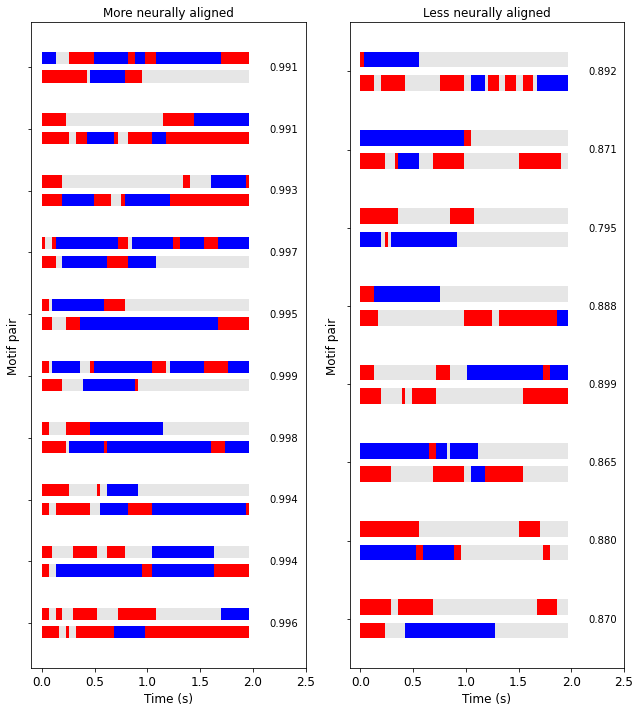

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 10), tight_layout=True)

# most similar motifs
y_ticks = []
for cidx, idx in enumerate(idx_aligned.nonzero()[0][:10]):
    motif_pair = motif_pairs[idx]
    alignment = alignments[idx]

    t_motifs = [np.arange(len(motif))*DT for motif in motif_pair]
    
    plot_b(axs[0], t_motifs[0], motif_pair[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[0], t_motifs[1], motif_pair[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])

    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[0].text(t_text, -cidx-.25, f'{alignment:.3f}', va='center')
    
    y_ticks.append(-cidx-.25)
    
set_plot(axs[0], x_lim=(-.1, T_SNP*1.25), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair', title='More neurally aligned')

# most similar motifs
y_ticks = []
for cidx, idx in enumerate(idx_unaligned.nonzero()[0][:10]):
    motif_pair = motif_pairs[idx]
    alignment = alignments[idx]

    t_motifs = [np.arange(len(motif))*DT for motif in motif_pair]
    
    plot_b(axs[1], t_motifs[0], motif_pair[0], extent=[0, t_motifs[0].max(), -cidx, -cidx-.2], c=[(.9, .9, .9), 'b', 'r'])
    plot_b(axs[1], t_motifs[1], motif_pair[1], extent=[0, t_motifs[0].max(), -cidx-.3, -cidx-.5], c=[(.9, .9, .9), 'b', 'r'])

    t_text = 1.1*np.max([t_motif.max() for t_motif in t_motifs])
    axs[1].text(t_text, -cidx-.25, f'{alignment:.3f}', va='center')
    
    y_ticks.append(-cidx-.25)
    
set_plot(axs[1], x_lim=(-.1, T_SNP*1.25), y_ticks=y_ticks, y_tick_labels=[], x_label='Time (s)', y_label='Motif pair', title='Less neurally aligned')

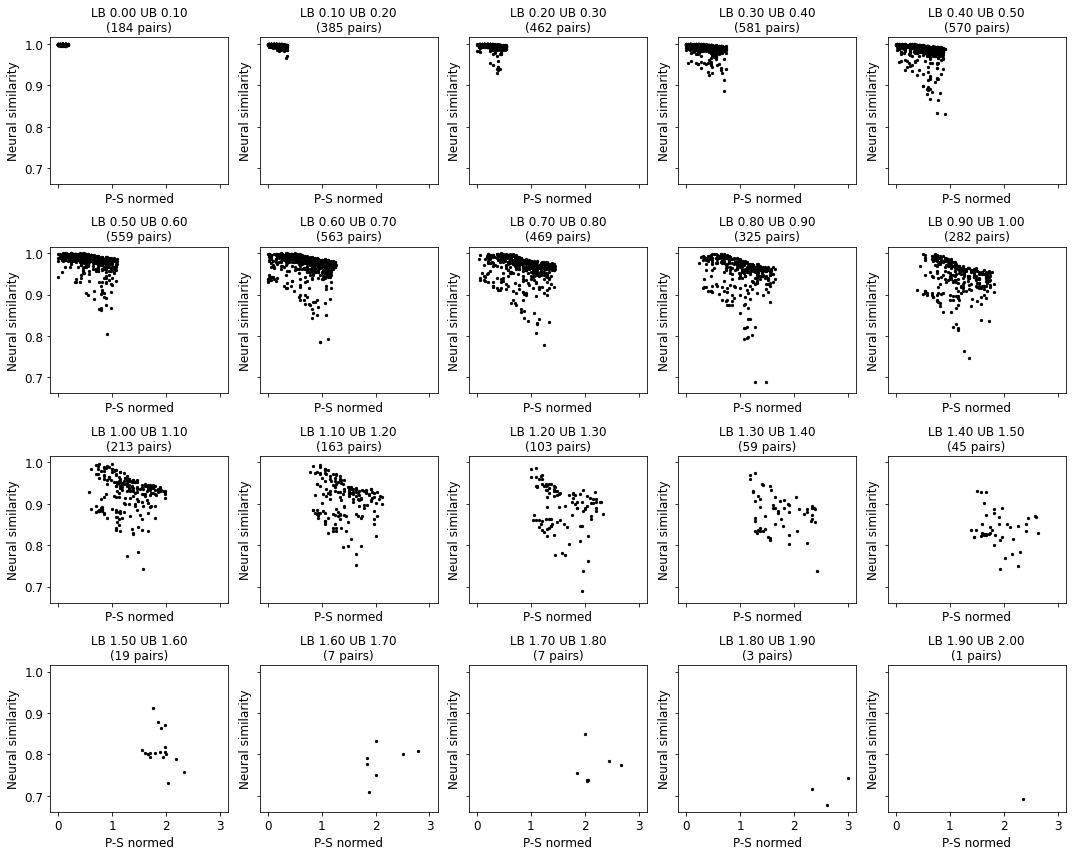

In [56]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12), tight_layout=True, sharex=True, sharey=True)

for lb, ax in zip(np.arange(0, 2, .1), axs.flatten()):
    ub = lb+.1
    mdiff = (lb <= diff_feats['max_s_p_total'])&(diff_feats['max_s_p_total'] < ub)
    
    # ax.hist(np.array(alignments)[mdiff])
    # set_plot(ax, x_label='Neural similarity', title=f'LB {lb:.2f} UB {ub:.2f}\n({mdiff.sum()} pairs)')
    
    ax.scatter(diff_feats['p_minus_s_normed'][mdiff], np.array(alignments)[mdiff], c='k', s=5)
    
    set_plot(ax, x_label='P-S normed', y_label='Neural similarity', title=f'LB {lb:.2f} UB {ub:.2f}\n({mdiff.sum()} pairs)')

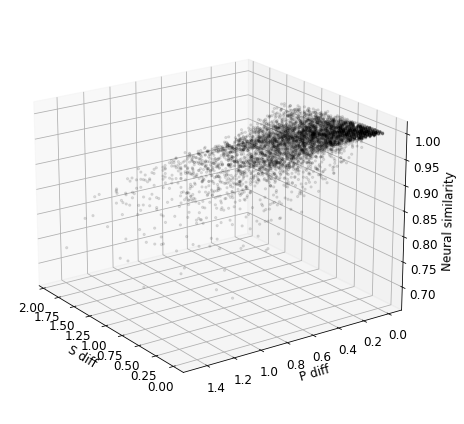

In [54]:
fig = plt.figure(figsize=(6, 6), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(diff_feats['s_total'], diff_feats['p_total'], alignments, s=5, c='k', alpha=.1)
ax.set_zlabel('Neural similarity')
set_plot(ax, x_label='S diff', y_label='P diff')

ax.view_init(elev=20, azim=145)